In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# データセットの読み込み
df = pd.read_csv('../data/raw/HAM10000_metadata.csv')

In [4]:
# 基本的な情報の確認
print("データセットの大きさ:", df.shape)
print("\n各カラムの情報:")
print(df.info())

データセットの大きさ: (10015, 7)

各カラムの情報:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB
None


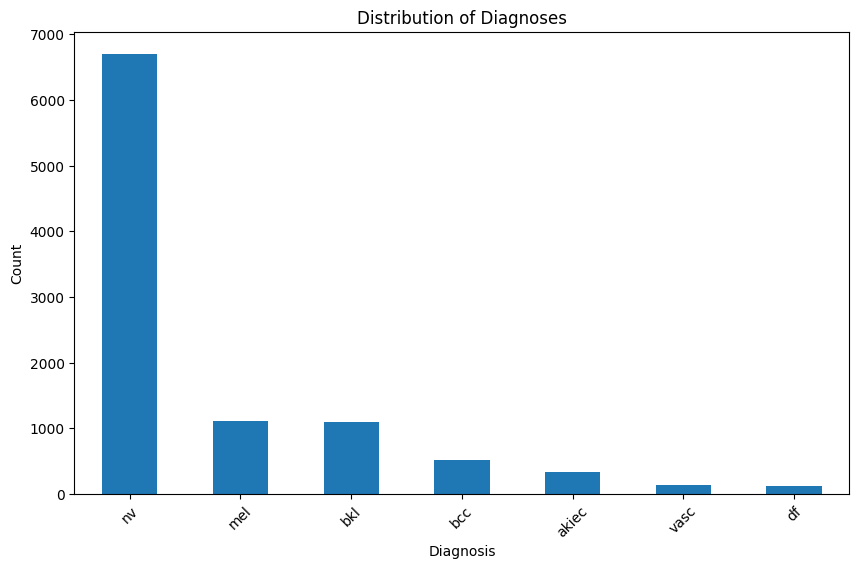

In [5]:
# 診断カテゴリの分布
plt.figure(figsize=(10, 6))
df['dx'].value_counts().plot(kind='bar')
plt.title('Distribution of Diagnoses')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

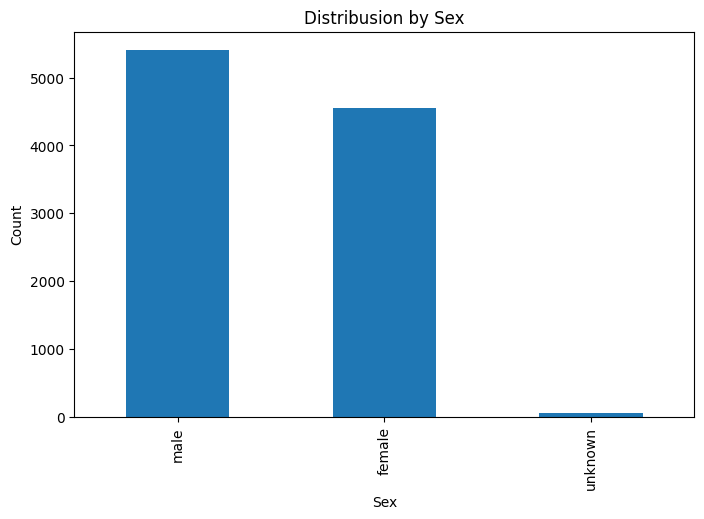

In [6]:
# 性別の分布
plt.figure(figsize=(8, 5))
df['sex'].value_counts().plot(kind='bar')
plt.title('Distribusion by Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

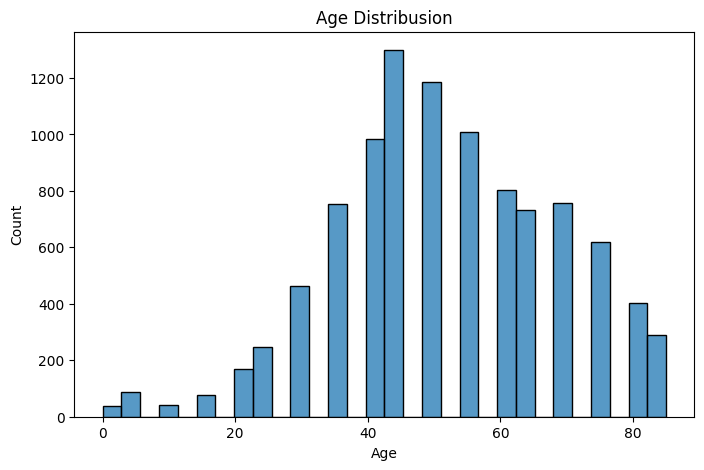

In [7]:
# 年齢の分布
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='age', bins=30)
plt.title('Age Distribusion')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

In [8]:
# 基本的な統計情報
print("\n年齢の統計情報:")
print(df['age'].describe())


年齢の統計情報:
count    9958.000000
mean       51.863828
std        16.968614
min         0.000000
25%        40.000000
50%        50.000000
75%        65.000000
max        85.000000
Name: age, dtype: float64


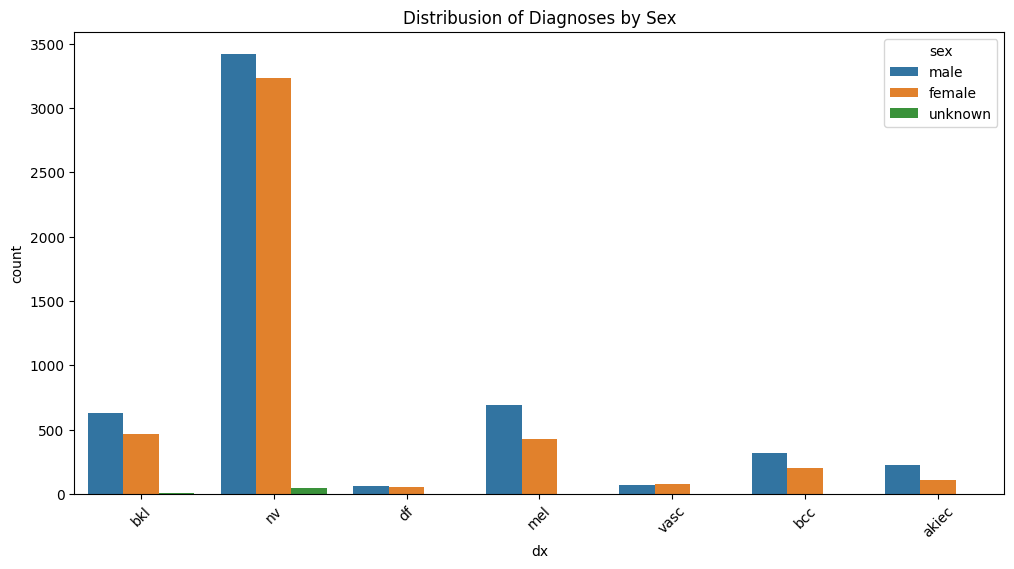

In [9]:
# 性別と診断の関係
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='dx', hue='sex')
plt.title('Distribusion of Diagnoses by Sex')
plt.xticks(rotation=45)
plt.show()

In [10]:
# それぞれの組み合わせのデータを抽出
nv_mel_df = df[df['dx'].isin(['nv', 'mel'])]
mel_bkl_df = df[df['dx'].isin(['mel', 'bkl'])]

# 基本統計量の確認
print("\nNV VS MEL:")
print(nv_mel_df['dx'].value_counts())
print("\nMEL VS BKL:")
print(mel_bkl_df['dx'].value_counts())


NV VS MEL:
dx
nv     6705
mel    1113
Name: count, dtype: int64

MEL VS BKL:
dx
mel    1113
bkl    1099
Name: count, dtype: int64


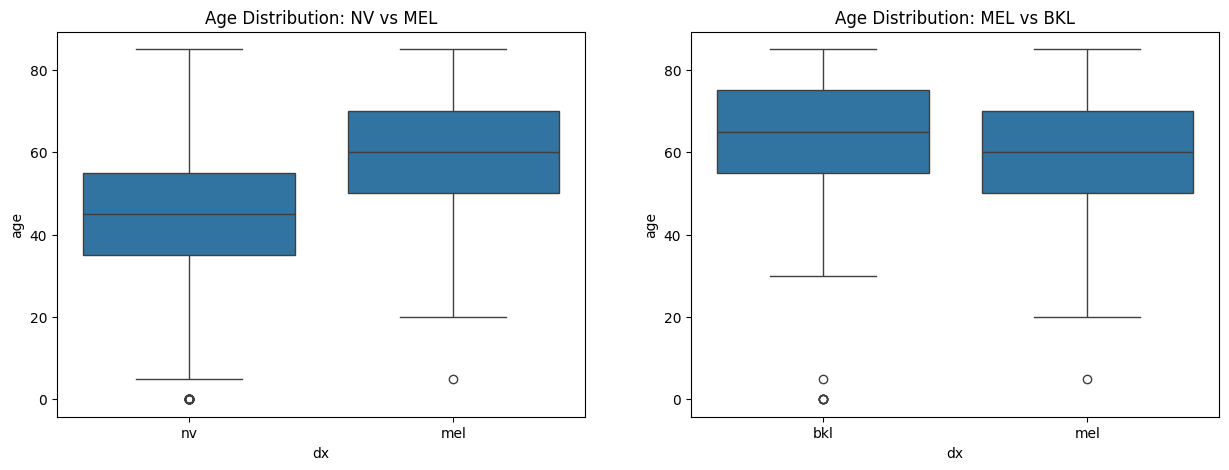

In [11]:
# 各組み合わせの年齢分布
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# NV vs MEL の年齢分布
sns.boxplot(data=nv_mel_df, x='dx', y='age', ax=ax1)
ax1.set_title('Age Distribution: NV vs MEL')

# MEL vs BKL の年齢分布
sns.boxplot(data=mel_bkl_df, x='dx', y='age', ax=ax2)
ax2.set_title('Age Distribution: MEL vs BKL')

plt.show()

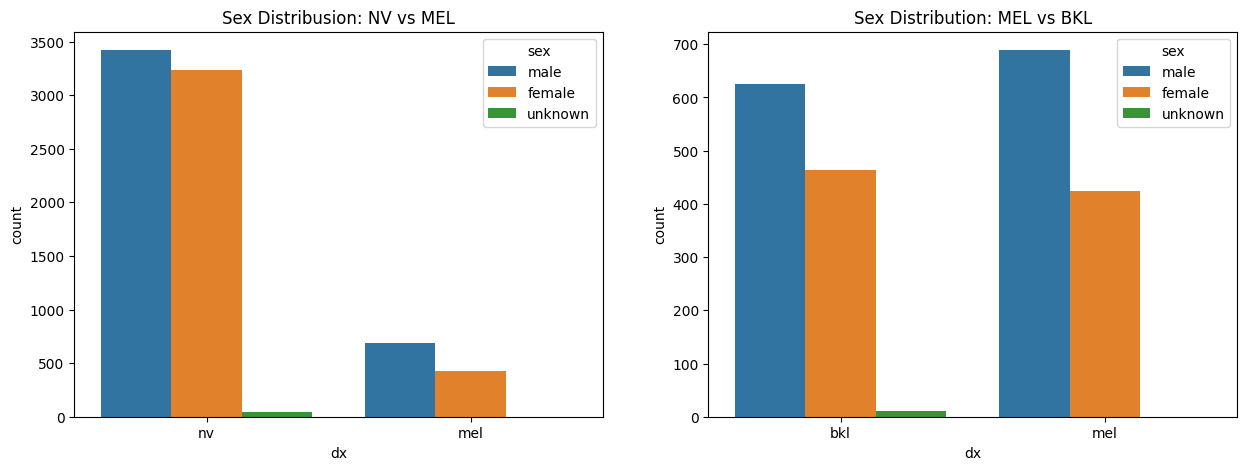

In [12]:
# 性別との関係
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# NV vs MEL の性別分布
sns.countplot(data=nv_mel_df, x='dx', hue='sex', ax=ax1)
ax1.set_title('Sex Distribusion: NV vs MEL')

# MEL vs BKL の性別分布
sns.countplot(data=mel_bkl_df, x='dx', hue='sex', ax=ax2)
ax2.set_title('Sex Distribution: MEL vs BKL')

plt.show()

In [13]:
import os
from PIL import Image

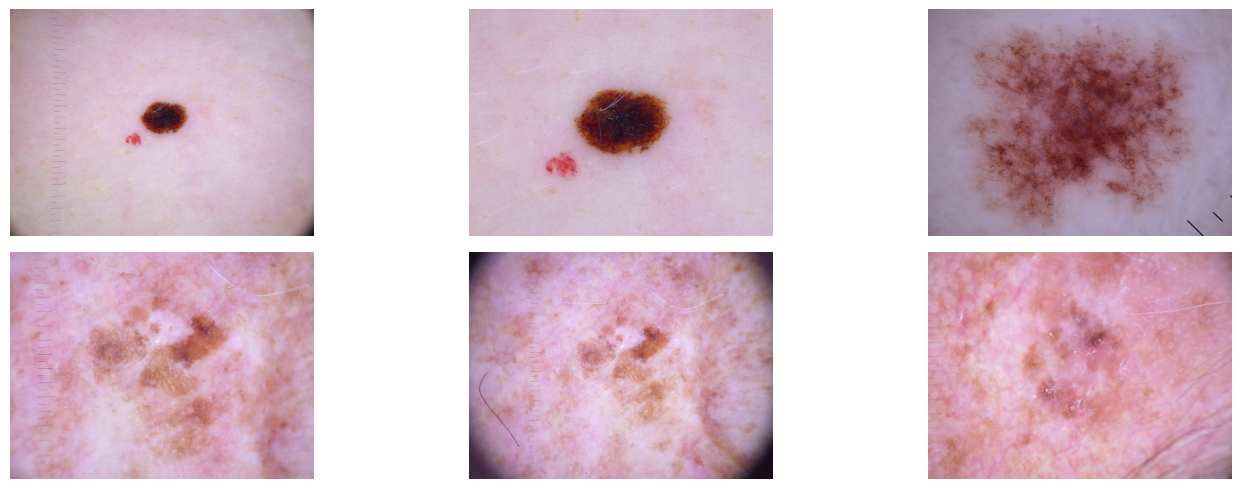

In [14]:
# MELとBKLの画像サンプルを表示する関数
def display_sample_images(df, dx_types, num_samples=3):
    fig, axes = plt.subplots(len(dx_types), num_samples, figsize=(15, 5))

    for i, dx in enumerate(dx_types):
        # 各診断タイプのサンプルを取得
        samples = df[df['dx'] == dx]['image_id'].values[:num_samples]

        for j, sample_id in enumerate(samples):
            # 画像を読み込み(相対パスを使用)
            img_path = f'../data/raw/{sample_id}.jpg'

            try:
                img = Image.open(img_path)
                axes[i, j].imshow(img)
                axes[i,j].axis('off')
                if j == 0:
                    axes[i, j].set_ylabel(dx.upper())
            except FileNotFoundError:
                print(f"画像が見つかりません: {img_path}")

    plt.tight_layout()
    plt.show()

# MELとBKLの画像を表示
display_sample_images(df, ['mel', 'bkl'])

In [15]:
import sys
sys.path.append('..') # notebooksディレクトリの一つ上に移動（プロジェクトルート）

In [16]:
print(sys.executable)

/Users/takadayuuki/skin-lesion-classifier/venv/bin/python


In [17]:
from src.data.data_processor import DataProcessor
import numpy as np
from sklearn.model_selection import train_test_split

In [18]:
# MELとBKLのデータのみ抽出
mel_bkl_df = df[df['dx'].isin(['mel', 'bkl'])].copy()

# ラベルをバイナリに変換(MEL:1, BKL:0)
mel_bkl_df['label'] = (mel_bkl_df['dx'] == 'mel').astype(int)

# DataProcessorのインスタンスを作成
processor = DataProcessor(image_size=(224, 224))

# tqdmをインポート(進捗表示用)
from tqdm import tqdm

# 画像データとラベルの準備
X = [] # 画像データを格納するリスト
y = [] # ラベルを格納するリスト

print("画像の前処理を開始...")
for idx, row in tqdm(mel_bkl_df.iterrows(), total=len(mel_bkl_df)):
    try:
        # 画像パスの生成
        img_path = f'../data/raw/{row["image_id"]}.jpg'
        # 画像の前処理
        img_array = processor.process_image(img_path)
        X.append(img_array)
        y.append(row['label'])
    except FileNotFoundError:
        print(f"画像が見つかりません: {img_path}")
        continue

画像の前処理を開始...


100%|██████████████████████████████████████| 2212/2212 [00:11<00:00, 190.05it/s]
